# COVID19 analisi

## Pacchetti utili

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

##  Modelli

In [2]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)*a))

def logistic(x,Par):
    return logistic_model(x,Par[0],Par[1],Par[2])

def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def logistic_model_derivative(x,a,b,c):
    return a*c*np.exp(-a*(x-b))/(1+np.exp(-(x-b)*a))**2

def logistic_derivative(x,Par):
    return Par[0]*Par[2]*np.exp(-Par[0]*(x-Par[1]))/(1+np.exp(-(x-Par[1])*Par[0]))**2

## Recuperiamo i dati da github

In [3]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)
df = df.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%d %H:%M:%S'
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )

x = list(df.iloc[:,0])
y = list(df.iloc[:,1])
YERR = np.sqrt(y)

### Fit logistico

In [9]:
P0=[0.3,70,5000]
fit = curve_fit(logistic_model,x,y,P0, sigma=YERR, absolute_sigma=True)

Par = [ii for ii in fit[0]]
ErrPar = [np.sqrt(fit[1][ii][ii]) for ii in range(3)]

print('\nLogistic fit parameters for total infected people:')
print('Rate of growth         =', fit[0][0])
print('Peak day from Jan 1st  =', fit[0][1])
print('Final number of deaths =', fit[0][2])

sol = int(fsolve(lambda x : logistic(x,Par) - int(Par[2]),Par[1]))


Logistic fit parameters for total infected people:
Rate of growth         = 0.23601218051955405
Peak day from Jan 1st  = 75.87734267748672
Final number of deaths = 63485.668861430924


In [10]:
YMIN=np.array(y)-np.array(YERR)
YMAX=np.array(y)+np.array(YERR)
fitMIN = curve_fit(logistic_model,x,YMIN,p0=Par, sigma=YERR, absolute_sigma=True)
fitMAX = curve_fit(logistic_model,x,YMAX,p0=Par, sigma=YERR, absolute_sigma=True)
ParMAX=[fitMAX[0][0],fitMAX[0][1],fitMAX[0][2]]
ParMIN=[fitMIN[0][0],fitMIN[0][1],fitMIN[0][2]]

### Fit esponenziale 

In [11]:
exp_fit = curve_fit(exponential_model,x,y,p0=[0.005,0.17,50])

# 

In [12]:
pred_x = list(range(max(x),sol))
xTOT= x+pred_x

In [13]:
y_pred_logistic = [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x]
# y_pred_exp =  [exponential_model(i,exp_fit[0][0], exp_fit[0][1],exp_fit[0][2]) for i in x]
print('\nMSE logistic curve:    ',mean_squared_error(y,y_pred_logistic))
# print('MSE exponential curve: ',mean_squared_error(y,y_pred_exp))


MSE logistic curve:     176433.37042441574


## Plots

In [14]:
# Plot andamento
plt.rcParams['figure.figsize'] = [9, 9]
plt.rc('font', size=16)

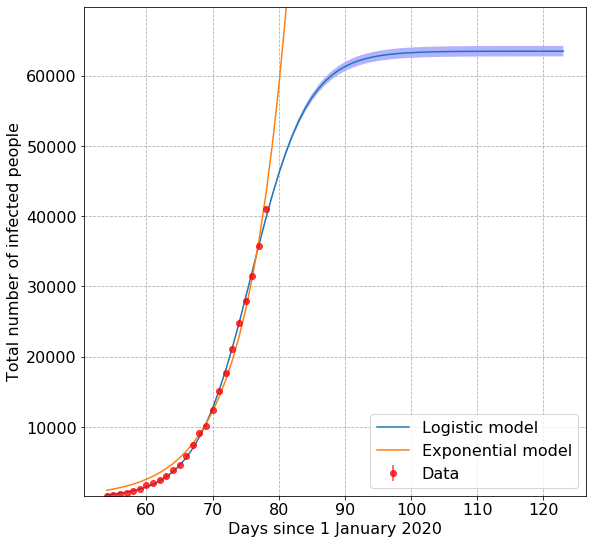

In [15]:
plt.figure('Deaths')
#Dati
plt.errorbar(x, y, yerr=YERR, fmt='o',color="red", alpha=0.75,label="Data" )
#Andamenti
plt.plot(xTOT, [logistic(i,Par) for i in xTOT], label="Logistic model" )
plt.fill_between(xTOT, [logistic(i,ParMAX) for i in xTOT],[logistic(i,ParMIN) for i in xTOT],facecolor='blue', alpha = 0.3 )
plt.plot(xTOT, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in xTOT], label="Exponential model" )

plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,Par[2]*1.1))
plt.grid(linestyle='--',which='both')
plt.show()

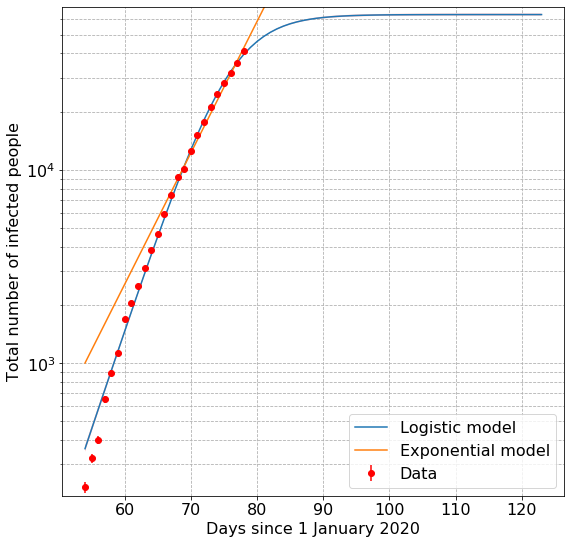

In [16]:
#Log Plot
plt.figure('Log Plot')
#Real data
plt.grid()
# plt.scatter(x,y,label="Real data",color="red")
plt.errorbar(x, y, yerr=YERR, fmt='o',color="red",label="Data" )
# Predicted logistic curve
plt.semilogy(xTOT, [logistic(i,Par) for i in xTOT], label="Logistic model" )
# Predicted exponential curve
plt.semilogy(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
plt.fill_between(xTOT, [logistic(i,ParMAX) for i in xTOT],[logistic(i,ParMIN) for i in xTOT],facecolor='red', alpha = 0.3 )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,Par[2]*1.1))
plt.grid(linestyle='--',which='both')
plt.show()


In [17]:
# Ratio and differences
Y2=np.array(y)
Y1=np.array(y)
Y1=np.delete(Y1,-1)
Y1=np.insert(Y1,0,Y1[0])

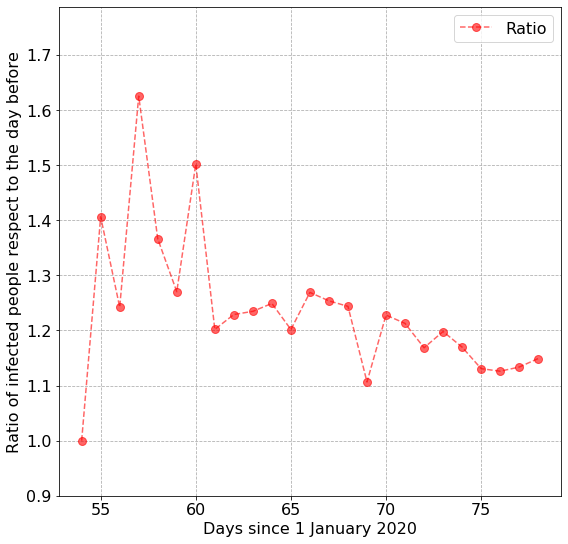

In [18]:
#Plot ratio
plt.figure('Ratio')
plt.plot(x,Y2/Y1,"--or",markersize=8,label="Ratio",alpha=0.6)
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Ratio of infected people respect to the day before")
plt.ylim((min(Y2/Y1)*0.9,max(Y2/Y1)*1.1))
plt.grid(linestyle='--',which='both')
plt.show()

In [19]:
# differences
Y2=np.array(y)
Y1=np.array(y)
Y1=np.delete(Y1,-1)
Y1=np.insert(Y1,0,Y1[0])
Y3=Y2-Y1
ERRY3=np.sqrt(Y2+Y1)
X=np.array(x)
X=np.delete(X,15,axis=0)
Y3=np.delete(Y3,15,axis=0)
ERRY3=np.delete(ERRY3,15,axis=0)
fit_derivative = curve_fit(logistic_model_derivative,X,Y3,p0=[0.2,70,64000])
fdM = curve_fit(logistic_model_derivative,X,Y3+ERRY3,p0=[0.2,70,64000])
fdm = curve_fit(logistic_model_derivative,X,Y3-ERRY3,p0=[0.2,70,64000])
Ymin= [logistic_derivative(i,fdm[0]) for i in list(X)+pred_x]
Ymax= [logistic_derivative(i,fdM[0]) for i in list(X)+pred_x]

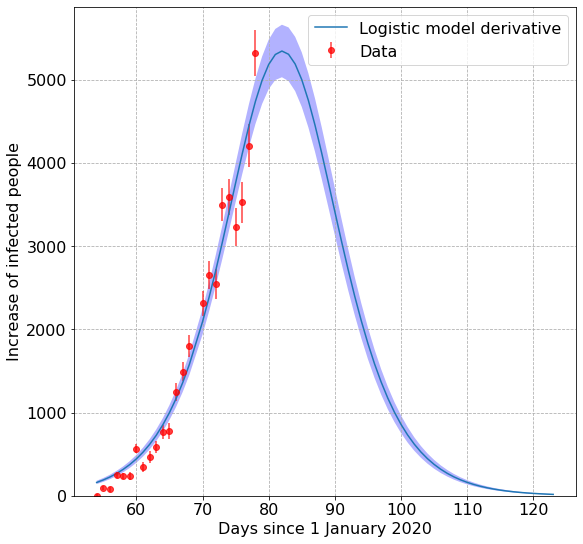

In [20]:
# Real data
plt.figure('Increases')
#plt.scatter(X,Y3,label="Real data",color="red", alpha=0.6)
plt.errorbar(X, Y3, yerr=ERRY3, fmt='o',color="red", alpha=0.75,label="Data" )
# Predicted logistic curve
plt.plot(list(X)+pred_x, [logistic_derivative(i,fit_derivative[0]) for i in list(X)+pred_x], label="Logistic model derivative" )
plt.fill_between(list(X)+pred_x,Ymin,Ymax,facecolor='blue', alpha = 0.3 )

plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Increase of infected people")
plt.ylim((min(Y3)*0.9,max([logistic_derivative(i,fit_derivative[0]) for i in list(X)+pred_x])*1.1))
plt.grid(linestyle='--',which='both')
plt.show()

# Predictions

In [21]:
NumberOfDaysPredicted=14
Xpredicted=[ii+max(x) for ii in range(1,NumberOfDaysPredicted+1)]
Ypredicted=[logistic(ii,Par) for ii in Xpredicted]

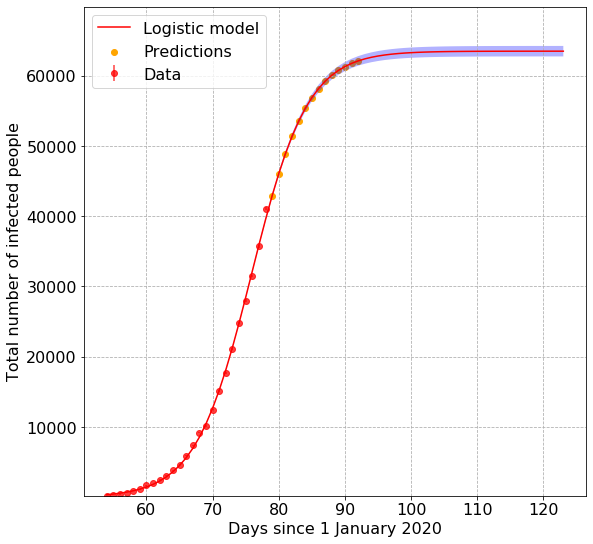

In [22]:
#Plot with predictions
plt.figure('Predictions')
# plt.scatter(x,y,label="Real data",color="red",linestyle="None")
plt.errorbar(x, y, yerr=YERR, fmt='o',color="red", alpha=0.75,label="Data" )
plt.scatter(Xpredicted, Ypredicted, color='orange', alpha=1,label="Predictions" )
# Predicted logistic curve
plt.fill_between(x+pred_x, [logistic_model(i,fitMAX[0][0],fitMAX[0][1],fitMAX[0][2]) for i in x+pred_x],[logistic_model(i,fitMIN[0][0],fitMIN[0][1],fitMIN[0][2]) for i in x+pred_x],facecolor='blue', alpha = 0.3 )
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], 'r',label="Logistic model" )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,Par[2]*1.1))
plt.grid(linestyle='--',which='both')
plt.show()